In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

# Function to calculate the area of dark blue stain and overlay contours on the image
def calculate_blue_area(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_dark_blue = np.array([90, 50, 50])
    upper_dark_blue = np.array([130, 255, 255])
    mask = cv2.inRange(hsv, lower_dark_blue, upper_dark_blue)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    blue_area = 0
    img_with_contours = img.copy()
    for contour in contours:
        blue_area += cv2.contourArea(contour)
        cv2.drawContours(img_with_contours, [contour], -1, (0, 255, 0), 2)
    return blue_area, img_with_contours

# Load and preprocess the image
img_path = 'D:/DATASET/CNN/fibrosis/train/3/47_97_13.png'
original_img = Image.open(img_path)
original_img = original_img.resize((299, 299))
img_array = np.array(original_img)

# Calculate blue stain area
blue_area, img_with_contours = calculate_blue_area(img_array)

# Display the result
plt.imshow(img_with_contours)
plt.title(f"Blue Area: {blue_area}")
plt.axis('off')
plt.show()

print(f"Calculated blue area: {blue_area}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to apply stain separation annotation
def separate_stains(image):
    gray = rgb2gray(image)
    thresh = threshold_otsu(gray)
    blue_mask = gray < thresh
    blue_stain = np.multiply(image, np.expand_dims(blue_mask, axis=-1))
    return blue_stain

# Function to calculate the area of dark blue stain and overlay contours on the image
def calculate_blue_area(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_dark_blue = np.array([90, 50, 50])
    upper_dark_blue = np.array([130, 255, 255])
    mask = cv2.inRange(hsv, lower_dark_blue, upper_dark_blue)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    blue_area = 0
    img_with_contours = img.copy()
    for contour in contours:
        blue_area += cv2.contourArea(contour)
        cv2.drawContours(img_with_contours, [contour], -1, (0, 255, 0), 2)
    return blue_area, img_with_contours

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return x

# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    img = Image.open(img_path)
    img = img.resize((299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return img, x

# Function to build a custom ResNet50-like model with adjustable kernel sizes
def build_custom_resnet50(kernel_size):
    input_tensor = tf.keras.Input(shape=(299, 299, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    
    # Modify the first convolutional layer to have the desired kernel size
    x = base_model.get_layer('conv1_relu').output
    x = Conv2D(64, kernel_size=kernel_size, strides=(2, 2), padding='same', activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(5, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Function to compile and train the model
def compile_and_train_model(model, train_dir, val_dir, epochs=3):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')
    val_generator = train_datagen.flow_from_directory(val_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')
    
    model.fit(train_generator, epochs=epochs, validation_data=val_generator)
    return model

# Define paths and other constants
train_dir = 'D:/DATASET/CNN/fibrosis/train'
val_dir = 'D:/DATASET/CNN/fibrosis/val'
img_path = 'D:/DATASET/CNN/fibrosis/train/3/47_97_13.png'

# List of kernel sizes to test
kernel_sizes = [(3, 3), (4, 4), (6, 6)]

# Loop through kernel sizes and evaluate
results = []
for kernel_size in kernel_sizes:
    print(f"Testing kernel size: {kernel_size}")
    model = build_custom_resnet50(kernel_size)
    model = compile_and_train_model(model, train_dir, val_dir, epochs=3)

    # Load and preprocess the image
    original_img, preprocessed_img = load_and_preprocess_image(img_path)
    
    # Predict and calculate blue stain area
    preds = model.predict(preprocessed_img)
    blue_area, img_with_contours = calculate_blue_area(np.array(original_img))

    # Save the result
    results.append((kernel_size, blue_area, img_with_contours))

    # Display the result
    plt.imshow(img_with_contours)
    plt.title(f"Kernel Size: {kernel_size}, Blue Area: {blue_area}")
    plt.axis('off')
    plt.show()

# Compare results and choose the best kernel size
best_kernel_size = None
max_blue_area = 0

for kernel_size, blue_area, img_with_contours in results:
    print(f"Kernel Size: {kernel_size}, Blue Area: {blue_area}")
    if blue_area > max_blue_area:
        max_blue_area = blue_area
        best_kernel_size = kernel_size

print(f"The best kernel size is: {best_kernel_size} with blue area: {max_blue_area}")


In [ ]:
# recent with feature maps

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to calculate the area of dark blue stain and overlay contours on the image
def calculate_blue_area(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_dark_blue = np.array([90, 50, 50])
    upper_dark_blue = np.array([130, 255, 255])
    mask = cv2.inRange(hsv, lower_dark_blue, upper_dark_blue)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    blue_area = 0
    img_with_contours = img.copy()
    for contour in contours:
        blue_area += cv2.contourArea(contour)
        cv2.drawContours(img_with_contours, [contour], -1, (0, 255, 0), 2)
    return blue_area, img_with_contours, mask

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return x

# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    img = Image.open(img_path)
    img = img.resize((299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return img, x

# Function to build a custom ResNet50-like model with adjustable kernel sizes
def build_custom_resnet50(kernel_size):
    input_tensor = tf.keras.Input(shape=(299, 299, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    
    # Modify the first convolutional layer to have the desired kernel size
    x = base_model.get_layer('conv1_relu').output
    x = Conv2D(64, kernel_size=kernel_size, strides=(2, 2), padding='same', activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(5, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Function to compile and train the model
def compile_and_train_model(model, train_dir, val_dir, epochs=3):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')
    val_generator = train_datagen.flow_from_directory(val_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')
    
    model.fit(train_generator, epochs=epochs, validation_data=val_generator)
    return model

# Function to generate feature maps
def generate_feature_map(model, img_path):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('conv5_block3_out').output)
    intermediate_output = intermediate_layer_model.predict(preprocess_image(img_path, target_size=(299, 299)))
    return intermediate_output

# Define paths and other constants
train_dir = 'D:/DATASET/CNN/fibrosis/train'
val_dir = 'D:/DATASET/CNN/fibrosis/val'
img_path = 'D:/DATASET/CNN/fibrosis/train/3/47_97_13.png'

# List of kernel sizes to test
kernel_sizes = [(3, 3), (4, 4), (6, 6)]

# Loop through kernel sizes and evaluate
results = []
for kernel_size in kernel_sizes:
    print(f"Testing kernel size: {kernel_size}")
    model = build_custom_resnet50(kernel_size)
    model = compile_and_train_model(model, train_dir, val_dir, epochs=3)

    # Load and preprocess the image
    original_img, preprocessed_img = load_and_preprocess_image(img_path)
    
    # Predict and calculate blue stain area
    preds = model.predict(preprocessed_img)
    blue_area, img_with_contours, mask = calculate_blue_area(np.array(original_img))

    # Extract feature map from the model
    feature_map = generate_feature_map(model, img_path)
    
    # Calculate blue area on the feature map
    feature_map_image = np.mean(feature_map[0], axis=-1)  # Average across the depth
    feature_map_image = cv2.normalize(feature_map_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    feature_map_image = cv2.cvtColor(feature_map_image, cv2.COLOR_GRAY2RGB)
    blue_area_feature_map, img_with_contours_feature_map, _ = calculate_blue_area(feature_map_image)

    # Save the result
    results.append((kernel_size, blue_area, blue_area_feature_map, img_with_contours, img_with_contours_feature_map))

    # Display the result
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_with_contours)
    plt.title(f"Original Image - Kernel Size: {kernel_size}, Blue Area: {blue_area}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_with_contours_feature_map)
    plt.title(f"Feature Map - Kernel Size: {kernel_size}, Blue Area: {blue_area_feature_map}")
    plt.axis('off')

    plt.show()

# Compare results and choose the best kernel size
best_kernel_size = None
max_blue_area = 0

for kernel_size, blue_area, blue_area_feature_map, _, _ in results:
    print(f"Kernel Size: {kernel_size}, Blue Area: {blue_area}, Blue Area Feature Map: {blue_area_feature_map}")
    if blue_area_feature_map > max_blue_area:
        max_blue_area = blue_area_feature_map
        best_kernel_size = kernel_size

print(f"The best kernel size is: {best_kernel_size} with blue area feature map: {max_blue_area}")


Testing kernel size: (3, 3)
Found 5349 images belonging to 5 classes.
Found 5349 images belonging to 5 classes.
Epoch 1/3
168/168 [==============================] - 621s 4s/step - loss: 0.9673 - accuracy: 0.6999 - val_loss: 0.9252 - val_accuracy: 0.7063
Epoch 2/3
168/168 [==============================] - 539s 3s/step - loss: 0.8803 - accuracy: 0.7220 - val_loss: 0.8385 - val_accuracy: 0.7463
Epoch 3/3
168/168 [==============================] - 692s 4s/step - loss: 0.8514 - accuracy: 0.7315 - val_loss: 0.8297 - val_accuracy: 0.7459


ValueError: No such layer: conv5_block3_out. Existing layers are: ['input_1', 'conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'conv2d', 'global_average_pooling2d', 'dense'].

In [ ]:
# Function to apply stain separation annotation
def separate_stains(image):
    gray = rgb2gray(image)
    thresh = threshold_otsu(gray)
    blue_mask = gray < thresh
    blue_stain = np.multiply(image, np.expand_dims(blue_mask, axis=-1))
    return blue_stain

# Function to calculate the area of dark blue stain and overlay contours on the image
def calculate_blue_area(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_dark_blue = np.array([90, 50, 50])
    upper_dark_blue = np.array([130, 255, 100])
    mask = cv2.inRange(hsv, lower_dark_blue, upper_dark_blue)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    blue_area = 0
    img_with_contours = img.copy()
    for contour in contours:
        blue_area += cv2.contourArea(contour)
        cv2.drawContours(img_with_contours, [contour], -1, (0, 255, 0), 2)
    return blue_area, img_with_contours

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return x

# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    img = Image.open(img_path)
    img = img.resize((299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return img, x

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to build a custom ResNet50-like model with adjustable kernel sizes
def build_custom_resnet50(kernel_size):
    input_tensor = tf.keras.Input(shape=(299, 299, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    
    # Modify specific layers to have the desired kernel size
    x = base_model.get_layer('conv1_relu').output
    x = Conv2D(64, kernel_size=kernel_size, strides=(2, 2), padding='same', activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(5, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Function to compile and train the model
def compile_and_train_model(model, train_dir, val_dir, epochs=3):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')
    val_generator = train_datagen.flow_from_directory(val_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')
    
    model.fit(train_generator, epochs=epochs, validation_data=val_generator)
    return model

# Define paths and other constants
train_dir = 'D:/DATASET/CNN/fibrosis/train'
val_dir = 'D:/DATASET/CNN/fibrosis/val'
img_path = 'D:/DATASET/CNN/fibrosis/train/3/47_97_13.png'

# List of kernel sizes to test
kernel_sizes = [(3, 3), (4, 4), (6, 6)]

# Loop through kernel sizes and evaluate
results = []
for kernel_size in kernel_sizes:
    print(f"Testing kernel size: {kernel_size}")
    model = build_custom_resnet50(kernel_size)
    model = compile_and_train_model(model, train_dir, val_dir, epochs=3)

    # Load and preprocess the image
    original_img, preprocessed_img = load_and_preprocess_image(img_path)
    
    # Predict and calculate blue stain area
    preds = model.predict(preprocessed_img)
    blue_area, img_with_contours = calculate_blue_area(np.array(original_img))

    # Save the result
    results.append((kernel_size, blue_area, img_with_contours))

    # Display the result
    plt.imshow(img_with_contours)
    plt.title(f"Kernel Size: {kernel_size}, Blue Area: {blue_area}")
    plt.axis('off')
    plt.show()

In [ ]:
# Compare results and choose the best kernel size
best_kernel_size = None
max_blue_area = 0

for kernel_size, blue_area, img_with_contours in results:
    print(f"Kernel Size: {kernel_size}, Blue Area: {blue_area}")
    if blue_area > max_blue_area:
        max_blue_area = blue_area
        best_kernel_size = kernel_size

print(f"The best kernel size is: {best_kernel_size} with blue area: {max_blue_area}")

In [ ]:
# try 1

Testing kernel size: (3, 3)
Found 5349 images belonging to 5 classes.
Found 5349 images belonging to 5 classes.
Epoch 1/3
168/168 [==============================] - 4057s 24s/step - loss: 1.0762 - accuracy: 0.7080 - val_loss: 0.8415 - val_accuracy: 0.7338
Epoch 2/3
168/168 [==============================] - 3311s 20s/step - loss: 0.6722 - accuracy: 0.7717 - val_loss: 0.8144 - val_accuracy: 0.7482
Epoch 3/3
168/168 [==============================] - 3311s 20s/step - loss: 0.6245 - accuracy: 0.7764 - val_loss: 0.7924 - val_accuracy: 0.7179


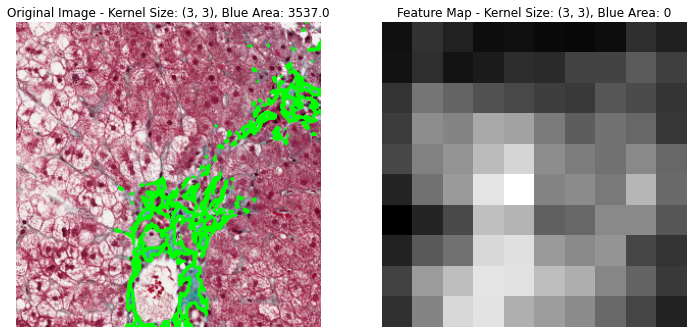

Testing kernel size: (4, 4)
Found 5349 images belonging to 5 classes.
Found 5349 images belonging to 5 classes.
Epoch 1/3
168/168 [==============================] - 3439s 20s/step - loss: 1.0353 - accuracy: 0.6822 - val_loss: 2.5977 - val_accuracy: 0.5250
Epoch 2/3
168/168 [==============================] - 3429s 20s/step - loss: 0.6952 - accuracy: 0.7484 - val_loss: 1.9799 - val_accuracy: 0.5652
Epoch 3/3
168/168 [==============================] - 3428s 20s/step - loss: 0.6423 - accuracy: 0.7629 - val_loss: 1.7810 - val_accuracy: 0.4051


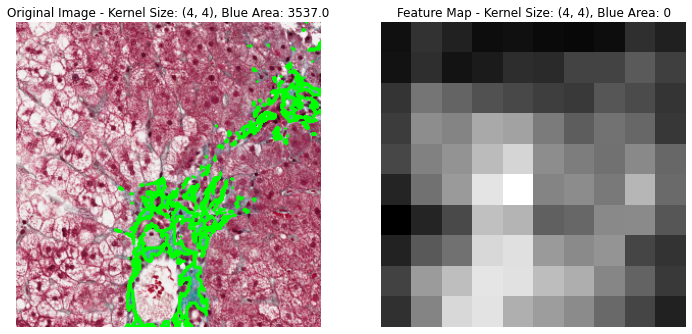

Testing kernel size: (6, 6)
Found 5349 images belonging to 5 classes.
Found 5349 images belonging to 5 classes.
Epoch 1/3
168/168 [==============================] - 3540s 21s/step - loss: 1.1377 - accuracy: 0.6889 - val_loss: 1.1782 - val_accuracy: 0.5752
Epoch 2/3
168/168 [==============================] - 3518s 21s/step - loss: 0.6780 - accuracy: 0.7573 - val_loss: 0.7367 - val_accuracy: 0.7390
Epoch 3/3
168/168 [==============================] - ETA: 0s - loss: 0.5944 - accuracy: 0.7798 

KeyboardInterrupt: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to calculate the area of dark blue stain and overlay contours on the image
def calculate_blue_area(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_dark_blue = np.array([90, 50, 50])
    upper_dark_blue = np.array([130, 255, 255])
    mask = cv2.inRange(hsv, lower_dark_blue, upper_dark_blue)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    blue_area = 0
    img_with_contours = img.copy()
    for contour in contours:
        blue_area += cv2.contourArea(contour)
        cv2.drawContours(img_with_contours, [contour], -1, (0, 255, 0), 2)
    return blue_area, img_with_contours, mask

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return x

# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    img = Image.open(img_path)
    img = img.resize((299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return img, x

# Function to build a custom ResNet50-like model with adjustable kernel sizes
def build_custom_resnet50(kernel_size):
    input_tensor = tf.keras.Input(shape=(299, 299, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    
    # Modify the first convolutional layer to have the desired kernel size
    x = base_model.output
    x = Conv2D(64, kernel_size=kernel_size, strides=(1, 1), padding='same', activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(5, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Function to compile and train the model
def compile_and_train_model(model, train_dir, val_dir, epochs=3):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')
    val_generator = train_datagen.flow_from_directory(val_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')
    
    model.fit(train_generator, epochs=epochs, validation_data=val_generator)
    return model

# Function to generate feature maps
def generate_feature_map(model, img_path):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    intermediate_layer_model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)
    intermediate_output = intermediate_layer_model.predict(preprocess_image(img_path, target_size=(299, 299)))
    return intermediate_output

# Define paths and other constants
train_dir = 'D:/DATASET/CNN/fibrosis/train'
val_dir = 'D:/DATASET/CNN/fibrosis/val'
img_path = 'D:/DATASET/CNN/fibrosis/train/3/47_97_13.png'

# List of kernel sizes to test
kernel_sizes = [(3, 3), (4, 4), (6, 6)]

# Loop through kernel sizes and evaluate
results = []
for kernel_size in kernel_sizes:
    print(f"Testing kernel size: {kernel_size}")
    model = build_custom_resnet50(kernel_size)
    model = compile_and_train_model(model, train_dir, val_dir, epochs=3)

    # Load and preprocess the image
    original_img, preprocessed_img = load_and_preprocess_image(img_path)
    
    # Predict and calculate blue stain area
    preds = model.predict(preprocessed_img)
    blue_area, img_with_contours, mask = calculate_blue_area(np.array(original_img))

    # Extract feature map from the model
    feature_map = generate_feature_map(model, img_path)
    
    # Calculate blue area on the feature map
    feature_map_image = np.mean(feature_map[0], axis=-1)  # Average across the depth
    feature_map_image = cv2.normalize(feature_map_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    feature_map_image = cv2.cvtColor(feature_map_image, cv2.COLOR_GRAY2RGB)
    blue_area_feature_map, img_with_contours_feature_map, _ = calculate_blue_area(feature_map_image)

    # Save the result
    results.append((kernel_size, blue_area, blue_area_feature_map, img_with_contours, img_with_contours_feature_map))

    # Display the result
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_with_contours)
    plt.title(f"Original Image - Kernel Size: {kernel_size}, Blue Area: {blue_area}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_with_contours_feature_map)
    plt.title(f"Feature Map - Kernel Size: {kernel_size}, Blue Area: {blue_area_feature_map}")
    plt.axis('off')

    plt.show()

# Compare results and choose the best kernel size
best_kernel_size = None
max_blue_area = 0

for kernel_size, blue_area, blue_area_feature_map, _, _ in results:
    print(f"Kernel Size: {kernel_size}, Blue Area: {blue_area}, Blue Area Feature Map: {blue_area_feature_map}")
    if blue_area_feature_map > max_blue_area:
        max_blue_area = blue_area_feature_map
        best_kernel_size = kernel_size

print(f"The best kernel size is: {best_kernel_size} with blue area feature map: {max_blue_area}")


Testing kernel size: (3, 3)
Found 5349 images belonging to 5 classes.
Found 5349 images belonging to 5 classes.
Epoch 1/3
168/168 [==============================] - 2884s 17s/step - loss: 0.9814 - accuracy: 0.7267 - val_loss: 1.0795 - val_accuracy: 0.7323
Epoch 2/3
168/168 [==============================] - 2908s 17s/step - loss: 0.6872 - accuracy: 0.7643 - val_loss: 6.2283 - val_accuracy: 0.3116
Epoch 3/3
168/168 [==============================] - 2900s 17s/step - loss: 0.6109 - accuracy: 0.7820 - val_loss: 1.4367 - val_accuracy: 0.6229


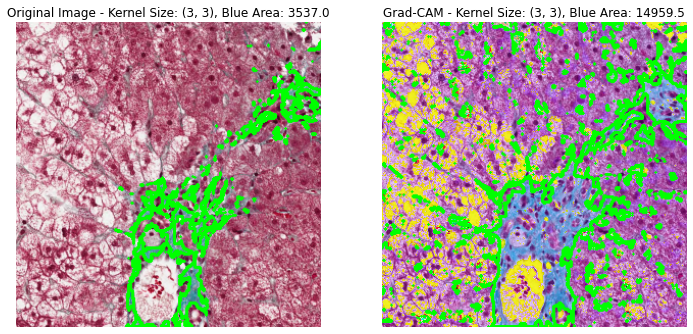

Testing kernel size: (4, 4)
Found 5349 images belonging to 5 classes.
Found 5349 images belonging to 5 classes.
Epoch 1/3
168/168 [==============================] - 4306s 26s/step - loss: 0.9682 - accuracy: 0.7231 - val_loss: 0.9456 - val_accuracy: 0.7181
Epoch 2/3
168/168 [==============================] - 3387s 20s/step - loss: 0.6399 - accuracy: 0.7727 - val_loss: 1.1363 - val_accuracy: 0.6485
Epoch 3/3
168/168 [==============================] - 2810s 17s/step - loss: 0.5882 - accuracy: 0.7800 - val_loss: 1.6001 - val_accuracy: 0.5666


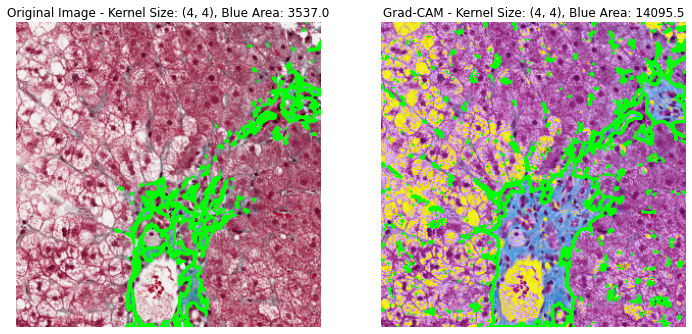

Testing kernel size: (6, 6)
Found 5349 images belonging to 5 classes.
Found 5349 images belonging to 5 classes.
Epoch 1/3
168/168 [==============================] - 2797s 17s/step - loss: 1.0592 - accuracy: 0.7173 - val_loss: 1.7284 - val_accuracy: 0.6986
Epoch 2/3
168/168 [==============================] - 2783s 17s/step - loss: 0.6583 - accuracy: 0.7687 - val_loss: 1.0283 - val_accuracy: 0.6457
Epoch 3/3
168/168 [==============================] - 2913s 17s/step - loss: 0.5870 - accuracy: 0.7863 - val_loss: 0.6447 - val_accuracy: 0.7605


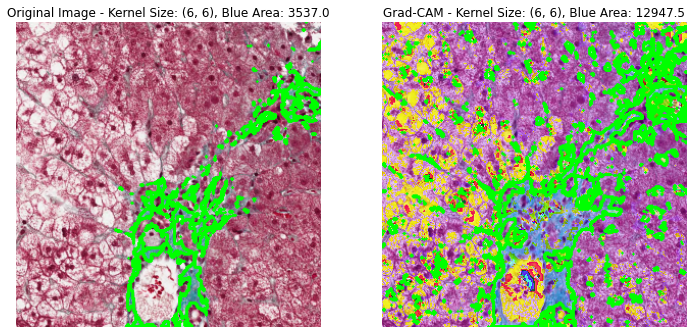

Kernel Size: (3, 3), Blue Area: 3537.0, Blue Area Grad-CAM: 14959.5
Kernel Size: (4, 4), Blue Area: 3537.0, Blue Area Grad-CAM: 14095.5
Kernel Size: (6, 6), Blue Area: 3537.0, Blue Area Grad-CAM: 12947.5
The best kernel size is: (3, 3) with blue area Grad-CAM: 14959.5


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

# Function to calculate the area of dark blue stain and overlay contours on the image
def calculate_blue_area(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_dark_blue = np.array([90, 50, 50])
    upper_dark_blue = np.array([130, 255, 255])
    mask = cv2.inRange(hsv, lower_dark_blue, upper_dark_blue)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    blue_area = 0
    img_with_contours = img.copy()
    for contour in contours:
        blue_area += cv2.contourArea(contour)
        cv2.drawContours(img_with_contours, [contour], -1, (0, 255, 0), 2)
    return blue_area, img_with_contours, mask

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return x

# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    img = Image.open(img_path)
    img = img.resize((299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return img, x

# Function to build a custom ResNet50-like model with adjustable kernel sizes
def build_custom_resnet50(kernel_size):
    input_tensor = tf.keras.Input(shape=(299, 299, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    
    # Modify the first convolutional layer to have the desired kernel size
    x = base_model.output
    x = Conv2D(64, kernel_size=kernel_size, strides=(1, 1), padding='same', activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(5, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Function to compile and train the model
def compile_and_train_model(model, train_dir, val_dir, epochs=3):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')
    val_generator = train_datagen.flow_from_directory(val_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')
    
    model.fit(train_generator, epochs=epochs, validation_data=val_generator)
    return model

# Function to generate Grad-CAM heatmap
def grad_cam(model, img_array, layer_name):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)[0]
    output = conv_outputs[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.zeros(output.shape[:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    cam = cv2.resize(cam.numpy(), (299, 299))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    return heatmap

# Define paths and other constants
train_dir = 'D:/DATASET/CNN/fibrosis/train'
val_dir = 'D:/DATASET/CNN/fibrosis/val'
img_path = 'D:/DATASET/CNN/fibrosis/train/3/47_97_13.png'

# List of kernel sizes to test
kernel_sizes = [(3, 3), (4, 4), (6, 6)]

# Loop through kernel sizes and evaluate
results = []
for kernel_size in kernel_sizes:
    print(f"Testing kernel size: {kernel_size}")
    model = build_custom_resnet50(kernel_size)
    model = compile_and_train_model(model, train_dir, val_dir, epochs=3)

    # Load and preprocess the image
    original_img, preprocessed_img = load_and_preprocess_image(img_path)
    
    # Predict and calculate blue stain area
    preds = model.predict(preprocessed_img)
    blue_area, img_with_contours, mask = calculate_blue_area(np.array(original_img))

    # Generate Grad-CAM heatmap
    heatmap = grad_cam(model, preprocessed_img, 'conv2_block3_out')
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * 0.4 + np.array(original_img)

    # Calculate blue area on the Grad-CAM heatmap
    blue_area_gradcam, img_with_contours_gradcam, _ = calculate_blue_area(superimposed_img.astype(np.uint8))

    # Save the result
    results.append((kernel_size, blue_area, blue_area_gradcam, img_with_contours, img_with_contours_gradcam))

    # Display the result
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_with_contours)
    plt.title(f"Original Image - Kernel Size: {kernel_size}, Blue Area: {blue_area}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_with_contours_gradcam)
    plt.title(f"Grad-CAM - Kernel Size: {kernel_size}, Blue Area: {blue_area_gradcam}")
    plt.axis('off')

    plt.show()

# Compare results and choose the best kernel size
best_kernel_size = None
max_blue_area = 0

for kernel_size, blue_area, blue_area_gradcam, _, _ in results:
    print(f"Kernel Size: {kernel_size}, Blue Area: {blue_area}, Blue Area Grad-CAM: {blue_area_gradcam}")
    if blue_area_gradcam > max_blue_area:
        max_blue_area = blue_area_gradcam
        best_kernel_size = kernel_size

print(f"The best kernel size is: {best_kernel_size} with blue area Grad-CAM: {max_blue_area}")


In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image as keras_image

# Function to preprocess images
def preprocess_image(img_path, target_size=(299, 299)):
    img = keras_image.load_img(img_path, target_size=target_size)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to calculate blue stain area
def calculate_blue_area(img):
    lower_blue = np.array([100, 0, 0])
    upper_blue = np.array([255, 100, 100])
    mask = cv2.inRange(img, lower_blue, upper_blue)
    blue_area = np.sum(mask > 0)
    return blue_area

# Function to build and train the model with varying kernel sizes
def build_and_train_model(kernel_size, train_dir, val_dir, epochs=3):
    base_model = ResNet50(include_top=False, input_shape=(299, 299, 3), weights='imagenet')
    x = base_model.output
    x = Conv2D(64, kernel_size=kernel_size, activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')
    val_generator = val_datagen.flow_from_directory(val_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')
    
    model.fit(train_generator, epochs=epochs, validation_data=val_generator)
    
    return model

# Function to generate feature maps
def generate_feature_map(model, img_path):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('conv2d').output)
    intermediate_output = intermediate_layer_model.predict(preprocess_image(img_path, target_size=(299, 299)))
    return intermediate_output

# Function for guided backpropagation
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, tf.float32) * tf.cast(x > 0, tf.float32) * dy
    return tf.nn.relu(x), grad

def modify_backprop(model):
    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedRelu'}):
        layer_dict = [layer for layer in model.layers[1:] if hasattr(layer, 'activation')]
        for layer in layer_dict:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guided_relu
    return model

# Function to apply guided backpropagation
def guided_backpropagation(model, img):
    with tf.GradientTape() as tape:
        inputs = tf.cast(preprocess_image(img), tf.float32)
        tape.watch(inputs)
        outputs = model(inputs)
        top_class = tf.argmax(outputs[0])
    grads = tape.gradient(outputs[:, top_class], inputs)[0]
    return grads.numpy()

# Function to apply Grad-CAM
def grad_cam(model, img_array, layer_name):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    guided_grads = (output > 0) * (grads > 0) * grads
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.ones(output.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    cam = cv2.resize(cam.numpy(), (299, 299))
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

# Directories for your data
train_dir = 'D:/DATASET/CNN/fibrosis/train'
val_dir = 'D:/DATASET/CNN/fibrosis/val'
img_path = 'D:/DATASET/CNN/fibrosis/train/3/47_97_13.png'

# Vary kernel sizes
kernel_sizes = [(3, 3), (4, 4), (6, 6)]

for kernel_size in kernel_sizes:
    print(f"Testing kernel size: {kernel_size}")
    model = build_and_train_model(kernel_size, train_dir, val_dir, epochs=3)
    
    # Generate Grad-CAM and Guided Backpropagation
    img_array = preprocess_image(img_path, target_size=(299, 299))
    gradcam_output = grad_cam(model, img_array, 'conv2d')
    
    modified_model = modify_backprop(model)
    guided_backprop_output = guided_backpropagation(modified_model, img_path)
    
    # Calculate blue area on the Grad-CAM and Guided Backpropagation output
    gradcam_blue_area = calculate_blue_area(gradcam_output)
    guided_backprop_blue_area = calculate_blue_area(guided_backprop_output)
    
    print(f"Kernel Size: {kernel_size}, Grad-CAM Blue Area: {gradcam_blue_area}, Guided Backprop Blue Area: {guided_backprop_blue_area}")
    
    # Visualize results
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    ax[0].imshow(cv2.imread(img_path))
    ax[0].set_title(f'Original Image - Kernel Size: {kernel_size}')
    ax[0].axis('off')
    
    ax[1].imshow(gradcam_output, cmap='jet', alpha=0.5)
    ax[1].set_title(f'Grad-CAM - Kernel Size: {kernel_size}')
    ax[1].axis('off')
    
    ax[2].imshow(guided_backprop_output, cmap='jet', alpha=0.5)
    ax[2].set_title(f'Guided Backprop - Kernel Size: {kernel_size}')
    ax[2].axis('off')
    
    plt.show()


Testing kernel size: (3, 3)
Found 5349 images belonging to 5 classes.
Found 5349 images belonging to 5 classes.
Epoch 1/3
168/168 [==============================] - 1124s 7s/step - loss: 1.0997 - accuracy: 0.7018 - val_loss: 0.7117 - val_accuracy: 0.7357
Epoch 2/3
168/168 [==============================] - 1103s 7s/step - loss: 0.7098 - accuracy: 0.7431 - val_loss: 0.6537 - val_accuracy: 0.7437
Epoch 3/3
168/168 [==============================] - 1102s 7s/step - loss: 0.6473 - accuracy: 0.7577 - val_loss: 0.6086 - val_accuracy: 0.7618


ValueError: No such layer: conv2d. Existing layers are: ['input_10', 'conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_0_bn', 'conv2_block1_3_bn', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_3_bn', 'conv2_block2_add', 'conv2_block2_out', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'conv2_block3_3_conv', 'conv2_block3_3_bn', 'conv2_block3_add', 'conv2_block3_out', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_2_bn', 'conv3_block1_2_relu', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block1_0_bn', 'conv3_block1_3_bn', 'conv3_block1_add', 'conv3_block1_out', 'conv3_block2_1_conv', 'conv3_block2_1_bn', 'conv3_block2_1_relu', 'conv3_block2_2_conv', 'conv3_block2_2_bn', 'conv3_block2_2_relu', 'conv3_block2_3_conv', 'conv3_block2_3_bn', 'conv3_block2_add', 'conv3_block2_out', 'conv3_block3_1_conv', 'conv3_block3_1_bn', 'conv3_block3_1_relu', 'conv3_block3_2_conv', 'conv3_block3_2_bn', 'conv3_block3_2_relu', 'conv3_block3_3_conv', 'conv3_block3_3_bn', 'conv3_block3_add', 'conv3_block3_out', 'conv3_block4_1_conv', 'conv3_block4_1_bn', 'conv3_block4_1_relu', 'conv3_block4_2_conv', 'conv3_block4_2_bn', 'conv3_block4_2_relu', 'conv3_block4_3_conv', 'conv3_block4_3_bn', 'conv3_block4_add', 'conv3_block4_out', 'conv4_block1_1_conv', 'conv4_block1_1_bn', 'conv4_block1_1_relu', 'conv4_block1_2_conv', 'conv4_block1_2_bn', 'conv4_block1_2_relu', 'conv4_block1_0_conv', 'conv4_block1_3_conv', 'conv4_block1_0_bn', 'conv4_block1_3_bn', 'conv4_block1_add', 'conv4_block1_out', 'conv4_block2_1_conv', 'conv4_block2_1_bn', 'conv4_block2_1_relu', 'conv4_block2_2_conv', 'conv4_block2_2_bn', 'conv4_block2_2_relu', 'conv4_block2_3_conv', 'conv4_block2_3_bn', 'conv4_block2_add', 'conv4_block2_out', 'conv4_block3_1_conv', 'conv4_block3_1_bn', 'conv4_block3_1_relu', 'conv4_block3_2_conv', 'conv4_block3_2_bn', 'conv4_block3_2_relu', 'conv4_block3_3_conv', 'conv4_block3_3_bn', 'conv4_block3_add', 'conv4_block3_out', 'conv4_block4_1_conv', 'conv4_block4_1_bn', 'conv4_block4_1_relu', 'conv4_block4_2_conv', 'conv4_block4_2_bn', 'conv4_block4_2_relu', 'conv4_block4_3_conv', 'conv4_block4_3_bn', 'conv4_block4_add', 'conv4_block4_out', 'conv4_block5_1_conv', 'conv4_block5_1_bn', 'conv4_block5_1_relu', 'conv4_block5_2_conv', 'conv4_block5_2_bn', 'conv4_block5_2_relu', 'conv4_block5_3_conv', 'conv4_block5_3_bn', 'conv4_block5_add', 'conv4_block5_out', 'conv4_block6_1_conv', 'conv4_block6_1_bn', 'conv4_block6_1_relu', 'conv4_block6_2_conv', 'conv4_block6_2_bn', 'conv4_block6_2_relu', 'conv4_block6_3_conv', 'conv4_block6_3_bn', 'conv4_block6_add', 'conv4_block6_out', 'conv5_block1_1_conv', 'conv5_block1_1_bn', 'conv5_block1_1_relu', 'conv5_block1_2_conv', 'conv5_block1_2_bn', 'conv5_block1_2_relu', 'conv5_block1_0_conv', 'conv5_block1_3_conv', 'conv5_block1_0_bn', 'conv5_block1_3_bn', 'conv5_block1_add', 'conv5_block1_out', 'conv5_block2_1_conv', 'conv5_block2_1_bn', 'conv5_block2_1_relu', 'conv5_block2_2_conv', 'conv5_block2_2_bn', 'conv5_block2_2_relu', 'conv5_block2_3_conv', 'conv5_block2_3_bn', 'conv5_block2_add', 'conv5_block2_out', 'conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_1_relu', 'conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_2_relu', 'conv5_block3_3_conv', 'conv5_block3_3_bn', 'conv5_block3_add', 'conv5_block3_out', 'conv2d_7', 'global_average_pooling2d_7', 'dense_7'].

In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image as keras_image

# Function to preprocess images
def preprocess_image(img_path, target_size=(299, 299)):
    img = keras_image.load_img(img_path, target_size=target_size)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to calculate blue stain area
def calculate_blue_area(img):
    lower_blue = np.array([100, 0, 0])
    upper_blue = np.array([255, 100, 100])
    mask = cv2.inRange(img, lower_blue, upper_blue)
    blue_area = np.sum(mask > 0)
    return blue_area

# Function to build and train the model with varying kernel sizes
def build_and_train_model(kernel_size, train_dir, val_dir, epochs=3):
    base_model = ResNet50(include_top=False, input_shape=(299, 299, 3), weights='imagenet')
    x = base_model.output
    x = Conv2D(64, kernel_size=kernel_size, activation='relu', name='custom_conv')(x)
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')
    val_generator = val_datagen.flow_from_directory(val_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')
    
    model.fit(train_generator, epochs=epochs, validation_data=val_generator)
    
    return model

# Function to generate feature maps
def generate_feature_map(model, img_path):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('custom_conv').output)
    intermediate_output = intermediate_layer_model.predict(preprocess_image(img_path, target_size=(299, 299)))
    return intermediate_output

# Function for guided backpropagation
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, tf.float32) * tf.cast(x > 0, tf.float32) * dy
    return tf.nn.relu(x), grad

def modify_backprop(model):
    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedRelu'}):
        layer_dict = [layer for layer in model.layers[1:] if hasattr(layer, 'activation')]
        for layer in layer_dict:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guided_relu
    return model

# Function to apply guided backpropagation
def guided_backpropagation(model, img):
    with tf.GradientTape() as tape:
        inputs = tf.cast(preprocess_image(img), tf.float32)
        tape.watch(inputs)
        outputs = model(inputs)
        top_class = tf.argmax(outputs[0])
    grads = tape.gradient(outputs[:, top_class], inputs)[0]
    return grads.numpy()

# Function to apply Grad-CAM
def grad_cam(model, img_array, layer_name):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    guided_grads = (output > 0) * (grads > 0) * grads
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.ones(output.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    cam = cv2.resize(cam.numpy(), (299, 299))
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

# Directories for your data
train_dir = 'D:/DATASET/CNN/fibrosis/train'
val_dir = 'D:/DATASET/CNN/fibrosis/val'
img_path = 'D:/DATASET/CNN/fibrosis/train/3/47_97_13.png'

# Vary kernel sizes
kernel_sizes = [(3, 3), (4, 4), (6, 6)]

for kernel_size in kernel_sizes:
    print(f"Testing kernel size: {kernel_size}")
    model = build_and_train_model(kernel_size, train_dir, val_dir, epochs=3)
    
    # Generate Grad-CAM and Guided Backpropagation
    img_array = preprocess_image(img_path, target_size=(299, 299))
    gradcam_output = grad_cam(model, img_array, 'custom_conv')
    
    modified_model = modify_backprop(model)
    guided_backprop_output = guided_backpropagation(modified_model, img_path)
    
    # Calculate blue area on the Grad-CAM and Guided Backpropagation output
    gradcam_blue_area = calculate_blue_area(gradcam_output)
    guided_backprop_blue_area = calculate_blue_area(guided_backprop_output)
    
    print(f"Kernel Size: {kernel_size}, Grad-CAM Blue Area: {gradcam_blue_area}, Guided Backprop Blue Area: {guided_backprop_blue_area}")
    
    # Visualize results
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    ax[0].imshow(cv2.imread(img_path))
    ax[0].set_title(f'Original Image - Kernel Size: {kernel_size}')
    ax[0].axis('off')
    
    ax[1].imshow(gradcam_output, cmap='jet', alpha=0.5)
    ax[1].set_title(f'Grad-CAM - Kernel Size: {kernel_size}')
    ax[1].axis('off')
    
    ax[2].imshow(guided_backprop_output, cmap='jet', alpha=0.5)
    ax[2].set_title(f'Guided Backprop - Kernel Size: {kernel_size}')
    ax[2].axis('off')
    
    plt.show()



Testing kernel size: (3, 3)
Found 5349 images belonging to 5 classes.
Found 5349 images belonging to 5 classes.
Epoch 1/3
168/168 [==============================] - 1840s 11s/step - loss: 1.2187 - accuracy: 0.7274 - val_loss: 0.6530 - val_accuracy: 0.7712
Epoch 2/3
168/168 [==============================] - 1442s 9s/step - loss: 0.6464 - accuracy: 0.7747 - val_loss: 0.5805 - val_accuracy: 0.7914
Epoch 3/3
168/168 [==============================] - 1772s 11s/step - loss: 0.5823 - accuracy: 0.7899 - val_loss: 0.5675 - val_accuracy: 0.8052


InvalidArgumentError: Value for attr 'T' of bool is not in the list of allowed values: bfloat16, half, float, double, uint8, int8, uint16, int16, int32, uint32, uint64, int64, complex64, complex128
	; NodeDef: {{node Mul}}; Op<name=Mul; signature=x:T, y:T -> z:T; attr=T:type,allowed=[DT_BFLOAT16, DT_HALF, DT_FLOAT, DT_DOUBLE, DT_UINT8, DT_INT8, DT_UINT16, DT_INT16, DT_INT32, DT_UINT32, DT_UINT64, DT_INT64, DT_COMPLEX64, DT_COMPLEX128]; is_commutative=true> [Op:Mul]

In [ ]:
# Sequencial filters modified code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

# Function to calculate the area of dark blue stain and overlay contours on the image
def calculate_blue_area(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_dark_blue = np.array([90, 50, 50])
    upper_dark_blue = np.array([130, 255, 255])
    mask = cv2.inRange(hsv, lower_dark_blue, upper_dark_blue)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    blue_area = 0
    img_with_contours = img.copy()
    for contour in contours:
        blue_area += cv2.contourArea(contour)
        cv2.drawContours(img_with_contours, [contour], -1, (0, 255, 0), 2)
    return blue_area, img_with_contours, mask

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return x

# Function to build a modified ResNet50-like model with the three filters
def build_modified_resnet50():
    input_tensor = tf.keras.Input(shape=(299, 299, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    
    # Add 6x6 filter
    x = Conv2D(64, kernel_size=(6, 6), strides=(1, 1), padding='same', activation='relu')(base_model.output)
    
    # Apply blue region mask after 6x6 filter
    blue_mask = Lambda(lambda x: calculate_blue_area(x)[2])(x)
    x = x * blue_mask
    
    # Add 4x4 filter
    x = Conv2D(64, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu')(x)
    
    # Apply blue region mask after 4x4 filter
    blue_mask = Lambda(lambda x: calculate_blue_area(x)[2])(x)
    x = x * blue_mask
    
    # Add 2x2 filter
    x = Conv2D(64, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu')(x)
    
    # Apply blue region mask after 2x2 filter
    blue_mask = Lambda(lambda x: calculate_blue_area(x)[2])(x)
    x = x * blue_mask
    
    # Global pooling and dense layers
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(5, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Function to compile and train the model
def compile_and_train_model(model, train_dir, val_dir, epochs=3):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')
    val_generator = train_datagen.flow_from_directory(val_dir, target_size=(299, 299), batch_size=32, class_mode='categorical')
    
    model.fit(train_generator, epochs=epochs, validation_data=val_generator)
    return model

# Function to generate Grad-CAM heatmap
def grad_cam(model, img_array, layer_name):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)[0]
    output = conv_outputs[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.zeros(output.shape[:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    cam = cv2.resize(cam.numpy(), (299, 299))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    return heatmap

# Define paths and other constants
train_dir = 'D:/DATASET/CNN/fibrosis/train'
val_dir = 'D:/DATASET/CNN/fibrosis/val'
img_path = 'D:/DATASET/CNN/fibrosis/train/3/47_97_13.png'

# Build and train the modified model
modified_model = build_modified_resnet50()
modified_model = compile_and_train_model(modified_model, train_dir, val_dir, epochs=3)

# Load and preprocess the image
original_img, preprocessed_img = load_and_preprocess_image(img_path)

# Predict and calculate blue stain area using the modified model
preds = modified_model.predict(preprocessed_img)
blue_area_modified, img_with_contours_modified, _ = calculate_blue_area(np.array(original_img))

# Generate Grad-CAM heatmap for the modified model
heatmap_modified = grad_cam(modified_model, preprocessed_img, 'conv2_block3_out')
heatmap_modified = cv2.applyColorMap(np.uint8(255 * heatmap_modified), cv2.COLORMAP_JET)
heatmap_modified = cv2.cvtColor(heatmap_modified, cv2.COLOR_BGR2RGB)
superimposed_img_modified = heatmap_modified * 0.4 + np.array(original_img)

# Calculate blue area on the Grad-CAM heatmap for the modified model
blue_area_gradcam_modified, img_with_contours_gradcam_modified, _ = calculate_blue_area(superimposed_img_modified.astype(np.uint8))

# Compare with the original ResNet50 model
resnet50_model = build_custom_resnet50((3, 3))  # Using standard ResNet50
resnet50_model = compile_and_train_model(resnet50_model, train_dir, val_dir, epochs=3)
heatmap_resnet50 = grad_cam(resnet50_model, preprocessed_img, 'conv2_block3_out')
heatmap_resnet50 = cv2.applyColorMap(np.uint8(255 * heatmap_resnet50), cv2.COLORMAP_JET)
heatmap_resnet50 = cv2.cvtColor(heatmap_resnet50, cv2.COLOR_BGR2RGB)
superimposed_img_resnet50 = heatmap_resnet50 * 0.4 + np.array(original_img)
blue_area_gradcam_resnet50, img_with_contours_gradcam_resnet50, _ = calculate_blue_area(superimposed_img_resnet50.astype(np.uint8))

# Display the comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_with_contours_gradcam_modified)
plt.title(f"Modified Model Grad-CAM, Blue Area: {blue_area_gradcam_modified}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_with_contours_gradcam_resnet50)
plt.title(f"ResNet50 Grad-CAM, Blue Area: {blue_area_gradcam_resnet50}")
plt.axis('off')

plt.show()

print(f"The blue area detected by the modified model: {blue_area_gradcam_modified}")
print(f"The blue area detected by the original ResNet50 model: {blue_area_gradcam_resnet50}")


In [7]:
#Sequencial model loaded model

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer
import json


# Custom Layer to Calculate Blue Area in TensorFlow
class BlueAreaLayer(Layer):
    def __init__(self, **kwargs):
        super(BlueAreaLayer, self).__init__(**kwargs)
        # Define the convolutional layer inside the custom layer
        self.conv2d = tf.keras.layers.Conv2D(3, kernel_size=(1, 1), activation='linear')

    def call(self, inputs):
        # Apply the convolution to reduce the channels to 3
        img = self.conv2d(inputs)
        # Perform the blue area calculation
        hsv = tf.image.rgb_to_hsv(img)
        lower_dark_blue = tf.constant([0.5, 0.4, 0.4])
        upper_dark_blue = tf.constant([0.7, 1.0, 1.0])
        mask = tf.reduce_all(tf.logical_and(hsv >= lower_dark_blue, hsv <= upper_dark_blue), axis=-1)
        mask = tf.cast(mask, tf.float32)
        mask = tf.expand_dims(mask, axis=-1)  # Add a channel dimension
        return mask

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return x

# Function to build a modified ResNet50-like model with the three filters
def build_modified_resnet50():
    input_tensor = tf.keras.Input(shape=(299, 299, 3))
    weights_path = 'imagenet'
    base_model = ResNet50(weights=weights_path, include_top=False, input_tensor=input_tensor)
    
    # Use the custom BlueAreaLayer
    x = base_model.output
    blue_mask = BlueAreaLayer()(x)

    # Add convolutional layers
    x = Conv2D(64, kernel_size=(6, 6), strides=(1, 1), padding='same', activation='relu')(blue_mask)
    x = Conv2D(64, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu')(x)
    x = Conv2D(64, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(5, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


for i, layer in enumerate(modified_model.layers):
    print(i, layer.name)

    
for layer in modified_model.layers:
    layer.trainable = True




# Function to generate Grad-CAM heatmap
# Function to generate Grad-CAM heatmap
def grad_cam(model, img_array, layer_name):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])

    # Set the model to training mode
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=True)
        loss = predictions[:, tf.argmax(predictions[0])]
    
    # Compute the gradient of the loss with respect to the convolutional output
    grads = tape.gradient(loss, conv_outputs)
    
    if grads is None:
        raise ValueError(f"No gradients found for layer {layer_name}. Make sure the layer name is correct and the model is in training mode.")
    
    grads = grads[0]
    output = conv_outputs[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.zeros(output.shape[:2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    
    cam = cv2.resize(cam.numpy(), (299, 299))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    return heatmap

# Ensure the model is not in evaluation mode
modified_model.trainable = True

# Optionally unfreeze layers if needed
for layer in modified_model.layers:
    layer.trainable = True

# Generate Grad-CAM heatmap
try:
    heatmap = grad_cam(modified_model, preprocessed_img, 'conv5_block3_out')
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * 0.4 + np.array(original_img)
except ValueError as e:
    print(f"Error during Grad-CAM generation: {e}")



# Function to print model layers and their shapes
def print_model_layers(model):
    for i, layer in enumerate(model.layers):
        print(f"{i}: {layer.name} - {layer.output_shape}")

# Define paths and other constants
train_dir = 'D:/DATASET/CNN/fibrosis/train'
val_dir = 'D:/DATASET/CNN/fibrosis/val'
img_path = 'D:/DATASET/CNN/fibrosis/train/3/47_97_13.png'
model_path = 'C:/Users/JUHI/Downloads/Model_testing/modified_model.h5'
history_path = 'C:/Users/JUHI/Downloads/Model_testing/modified_model_history.json'

print("START: Build and train the modified model")

# Load the pre-trained model
modified_model = build_modified_resnet50()
modified_model.load_weights(model_path)

print("END: Build and train the modified model")

print("START: Load and preprocess the image")

# Load and preprocess the image
preprocessed_img = preprocess_image(img_path, target_size=(299, 299))
original_img = load_img(img_path)

print("END: Load and preprocess the image")

print("START: Predict and calculate blue stain area using the modified model")

# Predict and calculate blue stain area using the modified model
preds = modified_model.predict(preprocessed_img)

print("END: Predict and calculate blue stain area using the modified model")

print("START: Generate Grad-CAM heatmap for the modified model")

# Set the layer name to the last convolutional layer before pooling
layer_name = 'conv5_block3_out'  # This layer seems to be the last conv layer before pooling

# Generate Grad-CAM heatmap
try:
    heatmap = grad_cam(modified_model, preprocessed_img, layer_name)
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * 0.4 + np.array(original_img)

    # Save results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title(f"Original Image - Blue Area Detected")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM - Blue Area Detected")
    plt.axis('off')

    plt.savefig('D:/DATASET/gradcam_results.png')

    print("Grad-CAM successfully generated and saved.")

except ValueError as e:
    print(f"Error during Grad-CAM generation: {e}")

print("END OF PROGRAM")


0 input_6
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn